In [2]:
# import libraries
import pandas as pd
import matplotlib.pyplot as plt
from catboost import CatBoostClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import balanced_accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import time

In [3]:
# import data
df = pd.read_excel("Preprocessing/FDAcleaned.xlsx")

In [4]:
target_name = 'product_classification' # variable we are trying to predict
features = ['product_type', 'state'] # predictive features

data = df[features].copy() # isolate data to just the features
target = (df[target_name] == 'Class I').astype(int)


# handling missing values (CatBoost doesn't like them)
data[features] = data[features].fillna("missing")

# making sure everything is of type string
for column in features:
    data[column] = data[column].astype(str)

In [5]:
# Hyperparameters
tree_depth = 6
learning_rate = 0.03

# create the CatBoost model using the above hyperparameters
model = CatBoostClassifier(
    iterations=500,
    learning_rate=learning_rate,
    depth=tree_depth,
    loss_function="Logloss",
    verbose=False
)

# define the cross validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In the next cell, we will perform the stratified k-fold cross validation by applying our CatBoostClassifier to each fold. Performance will be evaluated using weighted f1 and accuracy.

Resources used:  
1) https://www.geeksforgeeks.org/machine-learning/handling-categorical-features-with-catboost/
2) https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html  
3) https://www.geeksforgeeks.org/machine-learning/catboost-cross-validation-and-hyperparameter-tuning/  
4) https://www.youtube.com/watch?v=glLNo1ZnmPA  
5) https://www.geeksforgeeks.org/machine-learning/how-to-plot-confusion-matrix-with-labels-in-sklearn/
    
Here, we perform our stratified k-fold cross validation. Because we are working with categorical features, fitting CatBoost to our data requires that we pass the 'cat_features' argument in order for it to function. Because 'cross_val_score' automatically calls model.fit(x_train, y_train) without the 'cat_features' argument, we run into a problem. Thus, it will be necessary to perform the stratified k-fold cross validation manually.   
  
The following code is based on resource 3.

Training time: 56.37 seconds
Inference time: 0.08 seconds
Mean Balanced Accuracy: 0.69
Mean Macro F1: 0.71


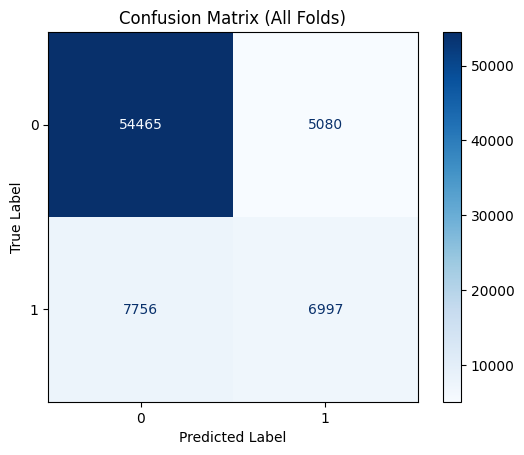

In [9]:
f1_scores = []
balanced_acc_scores = []

true = []
predicted = []

train_times = []
inference_times = []

# manually loop through the folds
for train_index, test_index in skf.split(data, target):
    X_train, X_val = data.iloc[train_index], data.iloc[test_index]
    y_train, y_val = target.iloc[train_index], target.iloc[test_index]

    # fit the model and record training time
    start_train_timer = time.time()
    model.fit(X_train, y_train, cat_features=features)
    end_train_timer = time.time()
    train_times.append(end_train_timer - start_train_timer)
    
    # make predictions and record inference time
    start_pred_timer = time.time()
    pred = model.predict(X_val)
    end_pred_timer = time.time()
    inference_times.append(end_pred_timer - start_pred_timer)

    # calculate metrics
    acc = balanced_accuracy_score(y_val, pred)
    f1 = f1_score(y_val, pred, average='macro')

    # true y-values and predicted, for the confusion matrix
    true += list(y_val)
    predicted += list(pred)
    
    # append metrics to their lists
    f1_scores.append(f1)
    balanced_acc_scores.append(acc)

# record the time it takes to process the data
print(f'Training time: {np.sum(train_times):.2f} seconds')
print(f'Inference time: {np.sum(inference_times):.2f} seconds')

# compute averages of the lists
print(f'Mean Balanced Accuracy: {np.mean(balanced_acc_scores):.2f}')
print(f'Mean Macro F1: {np.mean(f1_scores):.2f}')

# confusion matrix
cm = confusion_matrix(true, predicted)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix (All Folds)")
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()